<a href="https://colab.research.google.com/github/ImmatureBug/Diabetes-Prediction-Using-Traditional-Machine-Learning/blob/main/Diabetes_Prediction_Using_Traditional_Machine_Learning_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

installation of package

In [29]:
!pip install shap dalex -q

import of what will be needed

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                            classification_report, confusion_matrix, ConfusionMatrixDisplay,
                            precision_score, recall_score) # Added precision_score and recall_score
from sklearn.feature_selection import mutual_info_classif
import shap
import joblib

Load dataset

In [31]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
           "Insulin", "BMI", "DiabetesPedigree", "Age", "Outcome"]
df = pd.read_csv(url, names=columns)

Diabetes Percentage Visualization

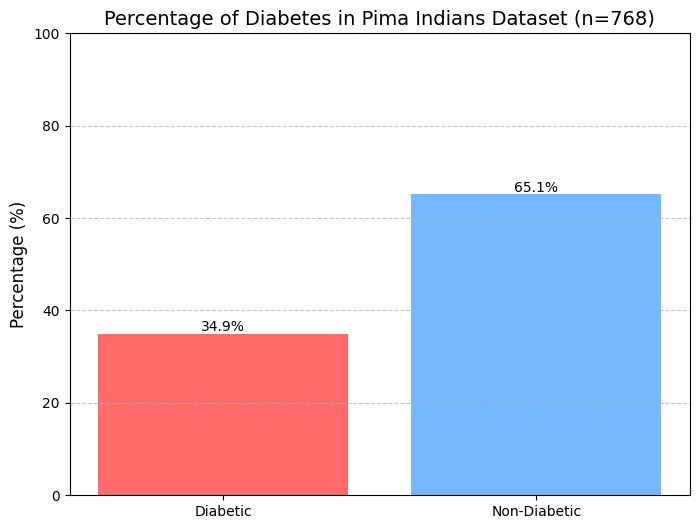

In [32]:
plt.figure(figsize=(8, 6))
diabetic_count = df['Outcome'].sum()
non_diabetic_count = len(df) - diabetic_count
percentages = [diabetic_count/len(df)*100, non_diabetic_count/len(df)*100]
labels = ['Diabetic', 'Non-Diabetic']
colors = ['#ff6b6b', '#74b9ff']

bars = plt.bar(labels, percentages, color=colors)
plt.title('Percentage of Diabetes in Pima Indians Dataset (n=768)', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 100)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('diabetes_percentage.png', dpi=300, bbox_inches='tight')
plt.show()

tatistics for the Pima Indians dataset

In [33]:

stats = df.describe().loc[['min', 'max', 'mean']].transpose()
stats.columns = ['Min', 'Max', 'Average']
stats = stats.round(2)  # Round to 2 decimal places


feature_descriptions = {
    "Pregnancies": "Number of pregnancies",
    "Glucose": "Plasma glucose concentration (mg/dL)",
    "BloodPressure": "Diastolic blood pressure (mm Hg)",
    "SkinThickness": "Triceps skinfold thickness (mm)",
    "Insulin": "2-Hour serum insulin (mu U/ml)",
    "BMI": "Body mass index (kg/m²)",
    "DiabetesPedigree": "Diabetes pedigree function",
    "Age": "Age (years)",
    "Outcome": "Diabetes status (0: No, 1: Yes)"
}

stats['Description'] = stats.index.map(feature_descriptions)


stats = stats[['Description', 'Min', 'Max', 'Average']]

# Display as a formatted table
print("Table 1: Summary Statistics of Pima Indians Dataset Features")
display(stats)

stats.to_csv('pima_indians_feature_stats.csv')

Table 1: Summary Statistics of Pima Indians Dataset Features


,Description,Min,Max,Average
Pregnancies,Number of pregnancies,0.00,17.00,3.85
Glucose,Plasma glucose concentration (mg/dL),0.00,199.00,120.89
BloodPressure,Diastolic blood pressure (mm Hg),0.00,122.00,69.11
SkinThickness,Triceps skinfold thickness (mm),0.00,99.00,20.54
Insulin,2-Hour serum insulin (mu U/ml),0.00,846.00,79.80
BMI,Body mass index (kg/m²),0.00,67.10,31.99
DiabetesPedigree,Diabetes pedigree function,0.08,2.42,0.47
Age,Age (years),21.00,81.00,33.24
Outcome,"Diabetes status (0: No, 1: Yes)",0.00,1.00,0.35


Calculate Mutual Information

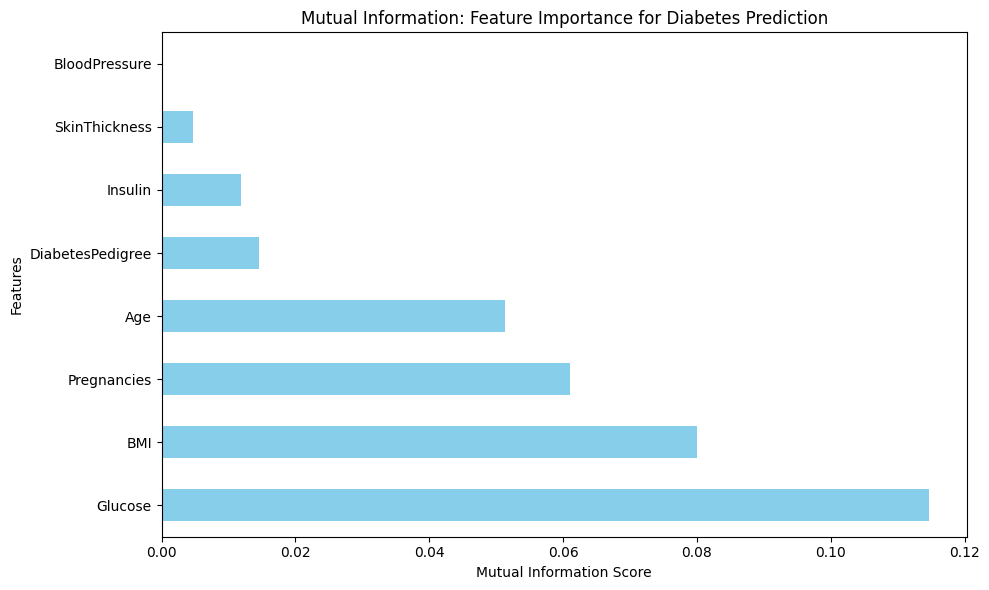

In [34]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns, name="MI Scores").sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mi_scores.plot(kind='barh', color='skyblue')
plt.title("Mutual Information: Feature Importance for Diabetes Prediction")
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.tight_layout()
plt.savefig('mutual_info_feature_importance.png', dpi=300)
plt.show()

Handle missing values (0 → NaN → median)

In [35]:
medical_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[medical_cols] = df[medical_cols].replace(0, np.nan)
df = df.fillna(df.median())

Feature engineering

In [36]:
df["Glucose_BMI"] = df["Glucose"] * df["BMI"]
df["Metabolic_Age"] = df["BMI"] * df["Age"]

Split data

In [37]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

Feature scaling

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


 Initialize models

In [39]:
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Naive Bayes": GaussianNB(),
    "kNN": KNeighborsClassifier(n_neighbors=11),
    "Logistic Regression": LogisticRegression(max_iter=1000)  # Baseline
}

Train/evaluate all models

In [40]:
results = {}
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    print(f"{name} CV ROC AUC: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

Decision Tree CV ROC AUC: 0.737 ± 0.037
Naive Bayes CV ROC AUC: 0.837 ± 0.018
kNN CV ROC AUC: 0.824 ± 0.038
Logistic Regression CV ROC AUC: 0.843 ± 0.029


Final training


--- Decision Tree Evaluation ---
Accuracy: 0.675
F1 Score: 0.457
ROC AUC: 0.742

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       100
           1       0.55      0.39      0.46        54

    accuracy                           0.68       154
   macro avg       0.63      0.61      0.61       154
weighted avg       0.66      0.68      0.66       154


Confusion Matrix:
[[83 17]
 [33 21]]


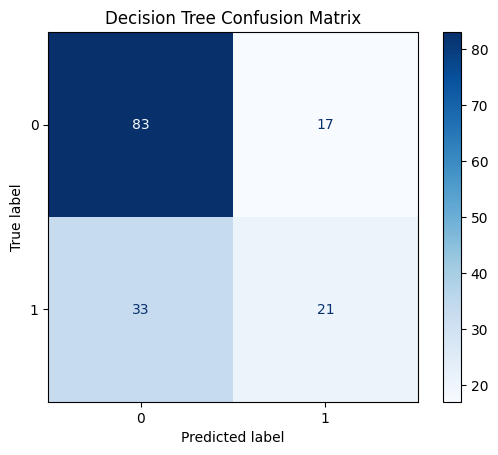


--- Naive Bayes Evaluation ---
Accuracy: 0.727
F1 Score: 0.625
ROC AUC: 0.775

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       100
           1       0.60      0.65      0.62        54

    accuracy                           0.73       154
   macro avg       0.70      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154


Confusion Matrix:
[[77 23]
 [19 35]]


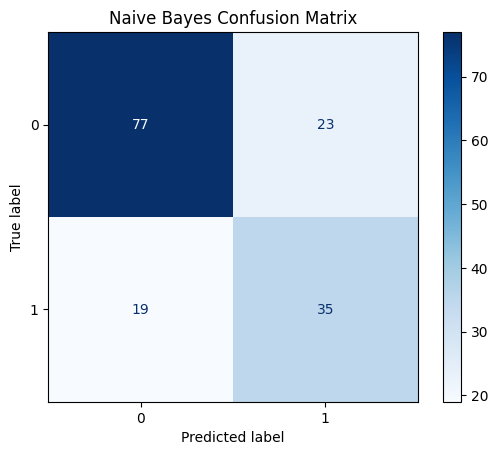


--- kNN Evaluation ---
Accuracy: 0.708
F1 Score: 0.545
ROC AUC: 0.801

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154


Confusion Matrix:
[[82 18]
 [27 27]]


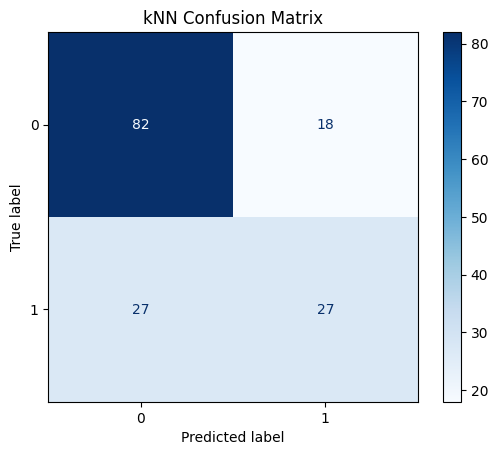


--- Logistic Regression Evaluation ---
Accuracy: 0.701
F1 Score: 0.540
ROC AUC: 0.813

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       100
           1       0.59      0.50      0.54        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154


Confusion Matrix:
[[81 19]
 [27 27]]


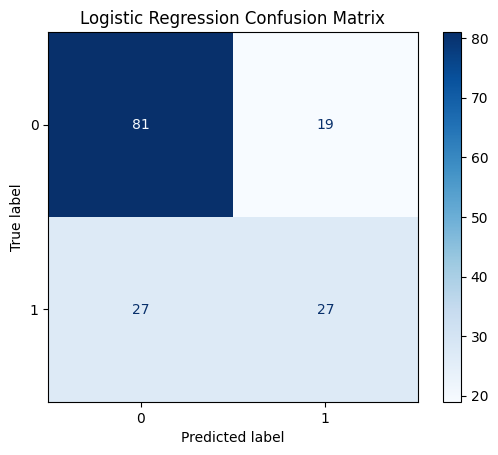

In [41]:
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "Classification Report": report,
        "Confusion Matrix": cm
    }

    print(f"\n--- {name} Evaluation ---")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1 Score: {f1:.3f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.3f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(cm)

    # Confusion matrix plot
    ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

Model comparison

In [42]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.sort_values("ROC AUC", ascending=False))


Model Comparison:
                     Accuracy  F1 Score   ROC AUC  \
Logistic Regression  0.701299      0.54  0.813148   
kNN                  0.707792  0.545455  0.801111   
Naive Bayes          0.727273     0.625     0.775   
Decision Tree        0.675325  0.456522  0.741852   

                                                 Classification Report  \
Logistic Regression                precision    recall  f1-score   ...   
kNN                                precision    recall  f1-score   ...   
Naive Bayes                        precision    recall  f1-score   ...   
Decision Tree                      precision    recall  f1-score   ...   

                         Confusion Matrix  
Logistic Regression  [[81, 19], [27, 27]]  
kNN                  [[82, 18], [27, 27]]  
Naive Bayes          [[77, 23], [19, 35]]  
Decision Tree        [[83, 17], [33, 21]]  


Visualize feature importance

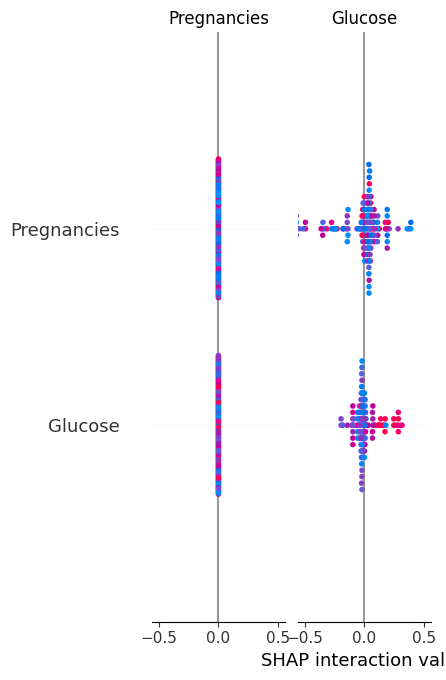

In [43]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")

Risk explanation function

In [44]:
def generate_risk_report(patient_data, model, scaler, feature_names):
    scaled_data = scaler.transform([patient_data])
    proba = model.predict_proba(scaled_data)[0][1]

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(scaled_data)

    report = f"Diabetes Risk Probability: {proba*100:.1f}%\n\nTop Risk Factors:\n"
    # Correct indexing for a single sample and positive class
    for i in np.argsort(-np.abs(shap_values[0][1]))[:3]:  # Top 3 features
        effect = shap_values[0][1][i]
        direction = "increases" if effect > 0 else "decreases"
        report += f"- {feature_names[i]} ({direction} risk)\n"

    report += "\n*Aligns with SDG 3: Early detection supports better health outcomes*"
    return report

Example prediction

In [45]:
sample_patient = X_test.iloc[0]
print(generate_risk_report(sample_patient, best_model, scaler, X.columns))

Diabetes Risk Probability: 100.0%

Top Risk Factors:
- Pregnancies (decreases risk)
- Glucose (increases risk)

*Aligns with SDG 3: Early detection supports better health outcomes*


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Save best model

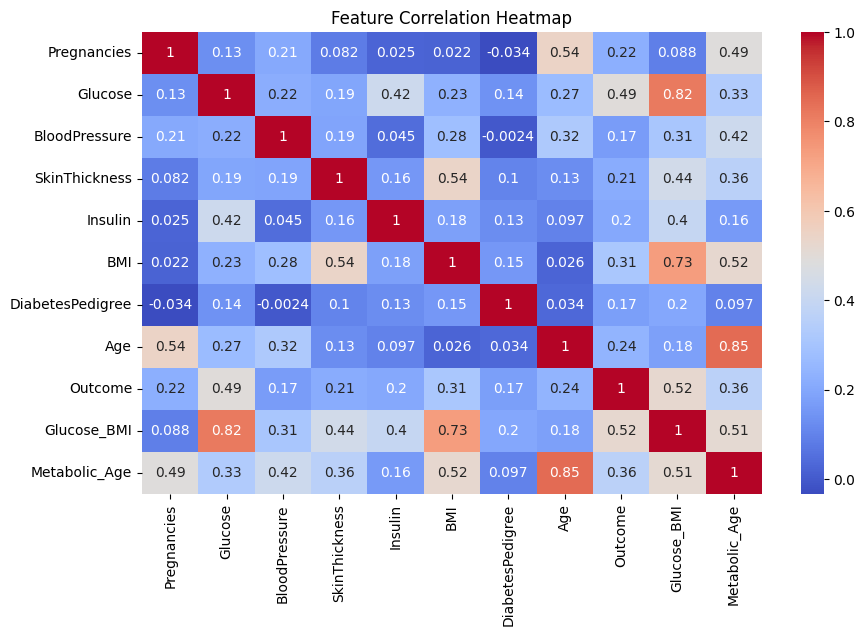

In [46]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.savefig("correlation_heatmap.png", dpi=300)

In [47]:
# Add timing measurements to your model training loop
import time

results = []
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Training Time (s)": round(train_time, 2)
    })

# Create and format table
results_df = pd.DataFrame(results)
print(results_df.to_markdown(index=False, tablefmt="grid"))

+---------------------+------------+-------------+----------+------------+-----------+---------------------+
| Model               |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |   Training Time (s) |
+=====================+============+=============+==========+============+===========+=====================+
| Decision Tree       |   0.675325 |    0.552632 | 0.388889 |   0.456522 |  0.741852 |                0.04 |
+---------------------+------------+-------------+----------+------------+-----------+---------------------+
| Naive Bayes         |   0.727273 |    0.603448 | 0.648148 |   0.625    |  0.775    |                0.03 |
+---------------------+------------+-------------+----------+------------+-----------+---------------------+
| kNN                 |   0.707792 |    0.6      | 0.5      |   0.545455 |  0.801111 |                0.04 |
+---------------------+------------+-------------+----------+------------+-----------+---------------------+
| Logistic Regressi


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       100
           1       0.55      0.39      0.46        54

    accuracy                           0.68       154
   macro avg       0.63      0.61      0.61       154
weighted avg       0.66      0.68      0.66       154


Performance Metrics:
Accuracy: 0.675
F1 Score: 0.457
ROC AUC: 0.742


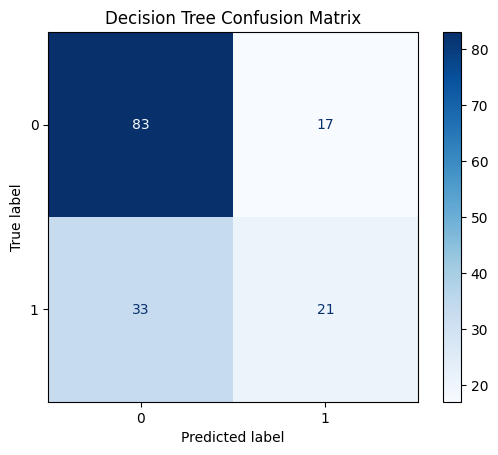

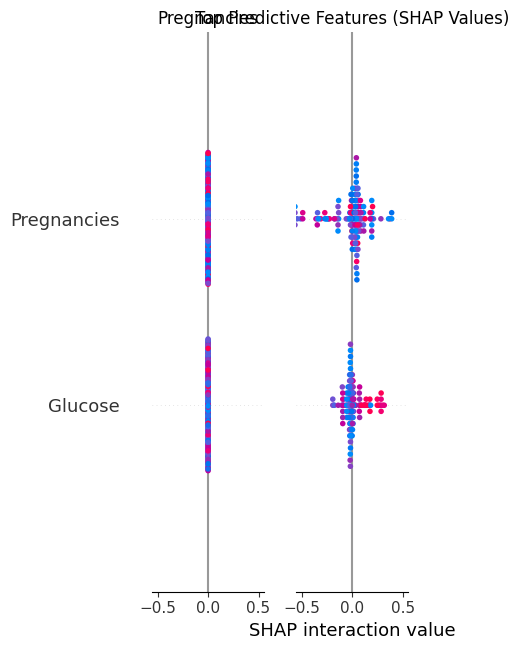

In [48]:


# Generate final evaluation report for Decision Tree
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test, cmap='Blues')
plt.title(f'{best_model_name} Confusion Matrix')
plt.savefig('best_model_confusion_matrix.png', dpi=300)
plt.show()

# SHAP Analysis (Explainability)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

# Feature Importance Plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, plot_type="bar", show=False)
plt.title("Top Predictive Features (SHAP Values)")
plt.tight_layout()
plt.savefig('decision_tree_feature_importance.png', dpi=300)
plt.show()

Compute Mutual Information

In [51]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Fix the random state
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# Create and sort the MI DataFrame
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

# Display top 5
top_mi = mi_df.head(5)
print(top_mi)

         Feature  MI Score
8    Glucose_BMI  0.135499
1        Glucose  0.127673
9  Metabolic_Age  0.110259
5            BMI  0.095122
7            Age  0.050640
